![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)

# <h1><center>Rollout Tutorial <a href="https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/rollout.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

This notebook provides a tutorial for [**MuJoCo** physics](https://github.com/google-deepmind/mujoco#readme), using the native Python bindings.

This notebook describes a utility included in the MuJoCo Python library that performs simulation "rollouts" with an underlying C++ function. The rollouts can be multithreaded. We provide examples of the speed of rollout compared to pure Python rollouts and MJX and give an application example that couples "rollout" with MuJoCo's "minimize" utility.

<!-- Copyright 2025 DeepMind Technologies Limited

     Licensed under the Apache License, Version 2.0 (the "License");
     you may not use this file except in compliance with the License.
     You may obtain a copy of the License at

         http://www.apache.org/licenses/LICENSE-2.0

     Unless required by applicable law or agreed to in writing, software
     distributed under the License is distributed on an "AS IS" BASIS,
     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
     See the License for the specific language governing permissions and
     limitations under the License.
-->

# All Imports

In [14]:
#@title All imports

!pip install mujoco
!pip install mujoco_mjx
!pip install brax

# Set up GPU rendering.
#from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  from mujoco import minimize
  from mujoco import rollout
  from mujoco import mjx
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

# Other imports and helper functions
import copy
import time
import timeit
from multiprocessing import cpu_count
import itertools
import numpy as np
import jax
import jax.numpy as jp

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()


# `rollout.rollout`

The `rollout.rollout` function in the `mujoco` Python library runs the simulation for a fixed number steps. It can run in single or multi-threaded modes. The speedup over pure Python is significant when using multithreading.

As a specific example let's consider the "tippe top" model (which is copied from the [tutorial notebook](https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/tutorial.ipynb)). The "tippe top" is a spinning toy which flips itself ([video](https://www.youtube.com/watch?v=kbYpVrdcszQ), [Wikipedia](https://en.wikipedia.org/wiki/Tippe_top)). The simulation reproduces this behaviour:

In [15]:
#@title Tippe Top
tippe_top = """
<mujoco model="tippe top">
  <option integrator="RK4"/>

  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>

  <worldbody>
    <geom size=".2 .2 .01" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
    <body name="top" pos="0 0 .02">
      <freejoint/>
      <geom name="ball" type="sphere" size=".02" />
      <geom name="stem" type="cylinder" pos="0 0 .02" size="0.004 .008"/>
      <geom name="ballast" type="box" size=".023 .023 0.005"  pos="0 0 -.015"
       contype="0" conaffinity="0" group="3"/>
    </body>
  </worldbody>

  <keyframe>
    <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0 0 0 1 200" />
  </keyframe>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(tippe_top)
data = mujoco.MjData(model)

# mujoco.mj_forward(model, data)
# with mujoco.Renderer(model) as renderer:
#   renderer.update_scene(data, camera="closeup")

#   media.show_image(renderer.render())
    
duration = 7    # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, "closeup")
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)

## Pure Python versus `rollout.rollout`

Lets simulate this model using a Python based rollout. We will time how long it takes to run a batch of 100 rollouts for 7 seconds of simulated time each.

In [16]:
duration = 7 # rollout duration (seconds)
N_batch = 100 # batch size
nstep = int(duration / model.opt.timestep)

def python_rollout():
  for i in range(N_batch):
    mujoco.mj_resetDataKeyframe(model, data, 0)
    while data.time < duration:
      mujoco.mj_step(model, data)

t_python_rollout = timeit.timeit(python_rollout, number=1)
print('Python rollout: {:0.3e} seconds per batch {:0.3e} rollouts per second'.format(t_python_rollout, N_batch / t_python_rollout))

Python rollout: 4.123e+00 seconds per batch 2.425e+01 rollouts per second


On an Intel 12800HX cpu, this takes about 3.5 seconds.

Next lets try `rollout.rollout`. It can execute the entire batch with single call. To use it we need to indicate that N_batch rollouts are to be performed on the same MjModel/MjData instance. We can do that by tiling the initial_state N_batch times.

In [17]:
mujoco.mj_resetDataKeyframe(model, data, 0)
initial_state = np.zeros((mujoco.mj_stateSize(model, mujoco.mjtState.mjSTATE_FULLPHYSICS),))
mujoco.mj_getState(model, data, initial_state, mujoco.mjtState.mjSTATE_FULLPHYSICS)
initial_states = np.tile(initial_state, (N_batch, 1))

def native_rollout_singlethreaded():
  rollout.rollout(model, data, initial_states, nstep=int(duration / model.opt.timestep))

N_timing = 1 # Number of times to run the benchmark for timing purposes
t_native_rollout = timeit.timeit(native_rollout_singlethreaded, number=N_timing) / N_timing

print('Native rollout multiple models: {:0.3e} seconds per batch {:0.2f} rollouts per second'.format(t_native_rollout, N_batch / t_native_rollout))
print('Speedup over pure python: {:0.3f}'.format(t_python_rollout / t_native_rollout))

Native rollout multiple models: 3.895e+00 seconds per batch 25.68 rollouts per second
Speedup over pure python: 1.059


This is only 5% faster than native Python. That is not very exciting.

To get a significant speedup we need to pass a list of MjData to `rollout.rollout`. One for each thread.

In [18]:
nthread = cpu_count()
print(f'Using {nthread} threads')

datas = [copy.copy(data) for _ in range(nthread)]
def native_rollout_multithreaded():
  rollout.rollout(model, datas, initial_states, nstep=int(duration / model.opt.timestep))

t_native_threaded_rollout = timeit.timeit(native_rollout_multithreaded, number=N_timing) / N_timing
print('Native rollout multithreaded: {:0.3e} seconds per batch {:0.2f} rollouts per second'.format(t_native_threaded_rollout, N_batch / t_native_threaded_rollout))
print('Speedup due to threaded rollout versus singled-threaded batched rollout: {:0.3f}'.format(t_python_rollout / t_native_threaded_rollout))

Using 24 threads
Native rollout multithreaded: 3.438e-01 seconds per batch 290.83 rollouts per second
Speedup due to threaded rollout versus singled-threaded batched rollout: 11.992


That's more like it. Thus, a one line change allows using 24 threads, achieving a >10x speedup.

Notice that `rollout.rollout` set's the initial state of the MjData instances using the required argument "initial_state". This allows all rollouts to use different initial conditions while sharing MjData instances.

## MJX versus `rollout.rollout`

### TODO why is MJX slower even with very large batch sizes?
### TODO why is the video different (darker) when run with MJX?
### TODO why does the top behave differently when run with MJX?

In [6]:
mj_model = model
mj_data = data

mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)

print(mj_data.qpos, type(mj_data.qpos))
print(mjx_data.qpos, type(mjx_data.qpos), mjx_data.qpos.devices())

jit_step = jax.jit(mjx.step)

# enable joint visualization option:
# scene_option = mujoco.MjvOption()
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

renderer = mujoco.Renderer(mj_model)

frames = []
mujoco.mj_resetData(mj_model, mj_data)
mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
while mj_data.time < duration:
  mujoco.mj_step(mj_model, mj_data)
  if len(frames) < mj_data.time * framerate:
    renderer.update_scene(mj_data)
    pixels = renderer.render()
    frames.append(pixels)

# Simulate and display video.
media.show_video(frames, fps=framerate)

jit_step = jax.jit(mjx.step)
renderer = mujoco.Renderer(mj_model)

frames = []
mujoco.mj_resetData(mj_model, mj_data)
mujoco.mj_resetDataKeyframe(mj_model, mj_data, 0)  # Reset the state to keyframe 0
mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)
while mjx_data.time < duration:
  mjx_data = jit_step(mjx_model, mjx_data)
  if len(frames) < mjx_data.time * framerate:
    mj_data = mjx.get_data(mj_model, mjx_data)
    renderer.update_scene(mj_data)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=framerate)

[ 0.023 -0.024  0.028  0.076  0.821 -0.565 -0.006] <class 'numpy.ndarray'>
[ 0.023 -0.024  0.028  0.076  0.821 -0.565 -0.006] <class 'jaxlib.xla_extension.ArrayImpl'> {CudaDevice(id=0)}


In [7]:
mujoco.mj_resetData(mj_model, mj_data)
mujoco.mj_resetDataKeyframe(mj_model, mj_data, 0)  # Reset the state to keyframe 0
mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)

N_batch = 10000
jit_step = jax.jit(jax.vmap(mjx.step, in_axes=(None, 0)))

def mjx_rollout(nstep):
  nstep = int(duration / model.opt.timestep)
  print(f'Running {N_batch} rollouts for {nstep} steps')
  batch = jax.vmap(lambda x: mjx_data)(jp.array(list(range(N_batch))))
  for _ in range(nstep):
    batch = jit_step(mjx_model, batch)

N_timing = 1
t_mjx_rollout = timeit.timeit(lambda: mjx_rollout(duration), number=N_timing) / N_timing
print('MJX rollout: {:0.3e} seconds per batch {:0.2f} rollouts per second'.format(t_mjx_rollout, N_batch / t_mjx_rollout))

Running 10000 rollouts for 3500 steps
MJX rollout: 1.070e+02 seconds per batch 93.49 rollouts per second


In [8]:
models = [copy.copy(model) for _ in range(N_batch)]

nthread = cpu_count()
print(f'Using {nthread} threads')
datas = [copy.copy(data) for _ in range(nthread)]

for d in datas:
  mujoco.mj_resetData(mj_model, d)
  mujoco.mj_resetDataKeyframe(mj_model, d, 0)  # Reset the state to keyframe 0

def native_rollout_multithreaded():
  nstep = int(duration / model.opt.timestep)
  print(f'Running {len(models)} rollouts for {nstep} steps')
  rollout.rollout(models, datas, initial_state, nstep=nstep)

t_native_threaded_rollout = timeit.timeit(native_rollout_multithreaded, number=N_timing) / N_timing
print('Native rollout multithreaded: {:0.3e} seconds per batch {:0.2f} rollouts per second'.format(t_native_threaded_rollout, N_batch / t_native_threaded_rollout))
print('native rollout runtime over MJX runtime: {:0.3f}'.format(t_native_threaded_rollout / t_mjx_rollout))

Using 24 threads
Running 10000 rollouts for 3500 steps
Native rollout multithreaded: 4.063e+01 seconds per batch 246.10 rollouts per second
native rollout runtime over MJX runtime: 0.380


## Detailed Usage
### TODO: Exercise every part of the rollout signature except for things covered in "Advanced Usage".

Let's look at `rollout.rollout`'s docstring and then go over how to use each argument.

In [9]:
print(rollout.rollout.__doc__)

Rolls out open-loop trajectories from initial states, get subsequent states and sensor values.

  Python wrapper for rollout.cc, see documentation therein.
  Infers nroll and nstep.
  Tiles inputs with singleton dimensions.
  Allocates outputs if none are given.

  Args:
    model: An instance or length nroll sequence of MjModel with the same size signature.
    data: Associated mjData instance or sequence of instances with length nthread.
    initial_state: Array of initial states from which to roll out trajectories.
      ([nroll or 1] x nstate)
    control: Open-loop controls array to apply during the rollouts.
      ([nroll or 1] x [nstep or 1] x ncontrol)
    control_spec: mjtState specification of control vectors.
    skip_checks: Whether to skip internal shape and type checks.
    nstep: Number of steps in rollouts (inferred if unspecified).
    initial_warmstart: Initial qfrc_warmstart array (optional).
      ([nroll or 1] x nv)
    state: State output array (optional).
      (

# Application: `rollout.rollout` + `minimize.least_squares`

`rollout.rollout` can be easily used with MuJoCo's nonlinear least squares utility, `minimize.least_squares`. Because `minimize` uses finite-differencing to estimate jacobians, it benefits greatly from multi-threaded rollouts.

As an example let's consider the "reach" sample from the [least squares notebook](https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/least_squares.ipynb). The code is copied here with a small modification that allows multithreading.

The goal is for the humanoid to reach a target with one of its hands. By default, the humanoid does a jump, but does not reach its hand to the target.

In [10]:
#@title Humanoid Reaching XML and code
xml = """
<mujoco model="Humanoid">
  <option timestep="0.005"/>

  <visual>
    <map force="0.1" zfar="30"/>
    <rgba haze="0.15 0.25 0.35 1"/>
    <global offwidth="2560" offheight="1440" elevation="-20" azimuth="120"/>
  </visual>

  <statistic center="0 0 0.7"/>

  <asset>
    <texture type="skybox" builtin="gradient" rgb1=".3 .5 .7" rgb2="0 0 0" width="32" height="512"/>
    <texture name="body" type="cube" builtin="flat" mark="cross" width="128" height="128" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" markrgb="1 1 1" random="0.01"/>
    <material name="body" texture="body" texuniform="true" rgba="0.8 0.6 .4 1"/>
    <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="1 1" texuniform="true" reflectance=".2"/>
  </asset>

  <default>
    <position inheritrange="0.95"/>
    <default class="body">

      <!-- geoms -->
      <geom type="capsule" condim="1" friction=".7" solimp="0.9 .99 .003" solref=".015 1" material="body" group="1"/>
      <default class="thigh">
        <geom size=".06"/>
      </default>
      <default class="shin">
        <geom fromto="0 0 0 0 0 -.3"  size=".049"/>
      </default>
      <default class="foot">
        <geom size=".027"/>
        <default class="foot1">
          <geom fromto="-.07 -.01 0 .14 -.03 0"/>
        </default>
        <default class="foot2">
          <geom fromto="-.07 .01 0 .14  .03 0"/>
        </default>
      </default>
      <default class="arm_upper">
        <geom size=".04"/>
      </default>
      <default class="arm_lower">
        <geom size=".031"/>
      </default>
      <default class="hand">
        <geom type="sphere" size=".04"/>
      </default>

      <!-- joints -->
      <joint type="hinge" damping=".2" stiffness="1" armature=".01" limited="true" solimplimit="0 .99 .01"/>
      <default class="joint_big">
        <joint damping="5" stiffness="10"/>
        <default class="hip_x">
          <joint range="-30 10"/>
        </default>
        <default class="hip_z">
          <joint range="-60 35"/>
        </default>
        <default class="hip_y">
          <joint axis="0 1 0" range="-150 20"/>
        </default>
        <default class="joint_big_stiff">
          <joint stiffness="20"/>
        </default>
      </default>
      <default class="knee">
        <joint pos="0 0 .02" axis="0 -1 0" range="-160 2"/>
      </default>
      <default class="ankle">
        <joint range="-50 50"/>
        <default class="ankle_y">
          <joint pos="0 0 .08" axis="0 1 0" stiffness="6"/>
        </default>
        <default class="ankle_x">
          <joint pos="0 0 .04" stiffness="3"/>
        </default>
      </default>
      <default class="shoulder">
        <joint range="-85 60"/>
      </default>
      <default class="elbow">
        <joint range="-100 50" stiffness="0"/>
      </default>
    </default>
  </default>

  <worldbody>
    <body name="target" pos=".2 -.2 1" mocap="true">
      <site name="target" size=".05" rgba="1 0 1 .4"/>
    </body>
    <geom name="floor" size="0 0 .05" type="plane" material="grid" condim="3"/>
    <light name="spotlight" mode="targetbodycom" target="torso" diffuse=".8 .8 .8" specular="0.3 0.3 0.3" pos="0 -6 4" cutoff="30"/>
    <body name="torso" pos="0 0 1.282" childclass="body">
      <light name="top" pos="0 0 2" mode="trackcom"/>
      <camera name="back" pos="-3 0 1" xyaxes="0 -1 0 1 0 2" mode="trackcom"/>
      <camera name="side" pos="0 -3 1" xyaxes="1 0 0 0 1 2" mode="trackcom"/>
      <freejoint name="root"/>
      <geom name="torso" fromto="0 -.07 0 0 .07 0" size=".07"/>
      <geom name="waist_upper" fromto="-.01 -.06 -.12 -.01 .06 -.12" size=".06"/>
      <body name="head" pos="0 0 .19">
        <geom name="head" type="sphere" size=".09"/>
        <camera name="egocentric" pos=".09 0 0" xyaxes="0 -1 0 .1 0 1" fovy="80"/>
      </body>
      <body name="waist_lower" pos="-.01 0 -.26">
        <geom name="waist_lower" fromto="0 -.06 0 0 .06 0" size=".06"/>
        <joint name="abdomen_z" pos="0 0 .065" axis="0 0 1" range="-45 45" class="joint_big_stiff"/>
        <joint name="abdomen_y" pos="0 0 .065" axis="0 1 0" range="-75 30" class="joint_big"/>
        <body name="pelvis" pos="0 0 -.165">
          <joint name="abdomen_x" pos="0 0 .1" axis="1 0 0" range="-35 35" class="joint_big"/>
          <geom name="butt" fromto="-.02 -.07 0 -.02 .07 0" size=".09"/>
          <body name="thigh_right" pos="0 -.1 -.04">
            <joint name="hip_x_right" axis="1 0 0" class="hip_x"/>
            <joint name="hip_z_right" axis="0 0 1" class="hip_z"/>
            <joint name="hip_y_right" class="hip_y"/>
            <geom name="thigh_right" fromto="0 0 0 0 .01 -.34" class="thigh"/>
            <body name="shin_right" pos="0 .01 -.4">
              <joint name="knee_right" class="knee"/>
              <geom name="shin_right" class="shin"/>
              <body name="foot_right" pos="0 0 -.39">
                <joint name="ankle_y_right" class="ankle_y"/>
                <joint name="ankle_x_right" class="ankle_x" axis="1 0 .5"/>
                <geom name="foot1_right" class="foot1"/>
                <geom name="foot2_right" class="foot2"/>
              </body>
            </body>
          </body>
          <body name="thigh_left" pos="0 .1 -.04">
            <joint name="hip_x_left" axis="-1 0 0" class="hip_x"/>
            <joint name="hip_z_left" axis="0 0 -1" class="hip_z"/>
            <joint name="hip_y_left" class="hip_y"/>
            <geom name="thigh_left" fromto="0 0 0 0 -.01 -.34" class="thigh"/>
            <body name="shin_left" pos="0 -.01 -.4">
              <joint name="knee_left" class="knee"/>
              <geom name="shin_left" fromto="0 0 0 0 0 -.3" class="shin"/>
              <body name="foot_left" pos="0 0 -.39">
                <joint name="ankle_y_left" class="ankle_y"/>
                <joint name="ankle_x_left" class="ankle_x" axis="-1 0 -.5"/>
                <geom name="foot1_left" class="foot1"/>
                <geom name="foot2_left" class="foot2"/>
              </body>
            </body>
          </body>
        </body>
      </body>
      <body name="upper_arm_right" pos="0 -.17 .06">
        <joint name="shoulder1_right" axis="2 1 1"  class="shoulder"/>
        <joint name="shoulder2_right" axis="0 -1 1" class="shoulder"/>
        <geom name="upper_arm_right" fromto="0 0 0 .16 -.16 -.16" class="arm_upper"/>
        <body name="lower_arm_right" pos=".18 -.18 -.18">
          <joint name="elbow_right" axis="0 -1 1" class="elbow"/>
          <geom name="lower_arm_right" fromto=".01 .01 .01 .17 .17 .17" class="arm_lower"/>
          <body name="hand_right" pos=".18 .18 .18">
            <geom name="hand_right" zaxis="1 1 1" class="hand" rgba="1 0 1 1"/>
          </body>
        </body>
      </body>
      <body name="upper_arm_left" pos="0 .17 .06">
        <joint name="shoulder1_left" axis="-2 1 -1" class="shoulder"/>
        <joint name="shoulder2_left" axis="0 -1 -1"  class="shoulder"/>
        <geom name="upper_arm_left" fromto="0 0 0 .16 .16 -.16" class="arm_upper"/>
        <body name="lower_arm_left" pos=".18 .18 -.18">
          <joint name="elbow_left" axis="0 -1 -1" class="elbow"/>
          <geom name="lower_arm_left" fromto=".01 -.01 .01 .17 -.17 .17" class="arm_lower"/>
          <body name="hand_left" pos=".18 -.18 .18">
            <geom name="hand_left" zaxis="1 -1 1" class="hand"/>
          </body>
        </body>
      </body>
    </body>
  </worldbody>

  <contact>
    <exclude body1="waist_lower" body2="thigh_right"/>
    <exclude body1="waist_lower" body2="thigh_left"/>
  </contact>

  <tendon>
    <fixed name="hamstring_right" limited="true" range="-0.3 2">
      <joint joint="hip_y_right" coef=".5"/>
      <joint joint="knee_right" coef="-.5"/>
    </fixed>
    <fixed name="hamstring_left" limited="true" range="-0.3 2">
      <joint joint="hip_y_left" coef=".5"/>
      <joint joint="knee_left" coef="-.5"/>
    </fixed>
  </tendon>

  <actuator>
    <position name="abdomen_z"       kp="40"  joint="abdomen_z"/>
    <position name="abdomen_y"       kp="40"  joint="abdomen_y"/>
    <position name="abdomen_x"       kp="40"  joint="abdomen_x"/>
    <position name="hip_x_right"     kp="40"  joint="hip_x_right"/>
    <position name="hip_z_right"     kp="40"  joint="hip_z_right"/>
    <position name="hip_y_right"     kp="120" joint="hip_y_right"/>
    <position name="knee_right"      kp="80"  joint="knee_right"/>
    <position name="ankle_y_right"   kp="20"  joint="ankle_y_right"/>
    <position name="ankle_x_right"   kp="20"  joint="ankle_x_right"/>
    <position name="hip_x_left"      kp="40"  joint="hip_x_left"/>
    <position name="hip_z_left"      kp="40"  joint="hip_z_left"/>
    <position name="hip_y_left"      kp="120" joint="hip_y_left"/>
    <position name="knee_left"       kp="80"  joint="knee_left"/>
    <position name="ankle_y_left"    kp="20"  joint="ankle_y_left"/>
    <position name="ankle_x_left"    kp="20"  joint="ankle_x_left"/>
    <position name="shoulder1_right" kp="20"  joint="shoulder1_right"/>
    <position name="shoulder2_right" kp="20"  joint="shoulder2_right"/>
    <position name="elbow_right"     kp="40"  joint="elbow_right"/>
    <position name="shoulder1_left"  kp="20"  joint="shoulder1_left"/>
    <position name="shoulder2_left"  kp="20"  joint="shoulder2_left"/>
    <position name="elbow_left"      kp="40"  joint="elbow_left"/>
  </actuator>

  <sensor>
    <framepos objtype="geom" objname="hand_right" reftype="xbody" refname="target"/>
    <actuatorfrc actuator="abdomen_z"/>
    <actuatorfrc actuator="abdomen_y"/>
    <actuatorfrc actuator="abdomen_x"/>
    <actuatorfrc actuator="hip_x_right"/>
    <actuatorfrc actuator="hip_z_right"/>
    <actuatorfrc actuator="hip_y_right"/>
    <actuatorfrc actuator="knee_right"/>
    <actuatorfrc actuator="ankle_y_right"/>
    <actuatorfrc actuator="ankle_x_right"/>
    <actuatorfrc actuator="hip_x_left"/>
    <actuatorfrc actuator="hip_z_left"/>
    <actuatorfrc actuator="hip_y_left"/>
    <actuatorfrc actuator="knee_left"/>
    <actuatorfrc actuator="ankle_y_left"/>
    <actuatorfrc actuator="ankle_x_left"/>
    <actuatorfrc actuator="shoulder1_right"/>
    <actuatorfrc actuator="shoulder2_right"/>
    <actuatorfrc actuator="elbow_right"/>
    <actuatorfrc actuator="shoulder1_left"/>
    <actuatorfrc actuator="shoulder2_left"/>
    <actuatorfrc actuator="elbow_left"/>
  </sensor>

  <keyframe>
    <!--
    The values below are split into rows for readibility:
      torso position
      torso orientation
      spinal
      right leg
      left leg
      arms
    -->
    <key name="squat"
         qpos="0 0 0.596
               0.988015 0 0.154359 0
               0 0.4 0
               -0.25 -0.5 -2.5 -2.65 -0.8 0.56
               -0.25 -0.5 -2.5 -2.65 -0.8 0.56
               0 0 0 0 0 0"/>
    <key name="stand_on_left_leg"
         qpos="0 0 1.21948
               0.971588 -0.179973 0.135318 -0.0729076
               -0.0516 -0.202 0.23
               -0.24 -0.007 -0.34 -1.76 -0.466 -0.0415
               -0.08 -0.01 -0.37 -0.685 -0.35 -0.09
               0.109 -0.067 -0.7 -0.05 0.12 0.16"/>
    <key name="prone"
         qpos="0.4 0 0.0757706
               0.7325 0 0.680767 0
               0 0.0729 0
               0.0077 0.0019 -0.026 -0.351 -0.27 0
               0.0077 0.0019 -0.026 -0.351 -0.27 0
               0.56 -0.62 -1.752
               0.56 -0.62 -1.752"/>
    <key name="supine"
         qpos="-0.4 0 0.08122
               0.722788 0 -0.69107 0
               0 -0.25 0
               0.0182 0.0142 0.3 0.042 -0.44 -0.02
               0.0182 0.0142 0.3 0.042 -0.44 -0.02
               0.186 -0.73 -1.73
               0.186 -0.73 -1.73"/>
  </keyframe>
</mujoco>
"""

# Load model, make data, make list of data for multithreading
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
data_list = [mujoco.MjData(model) for _ in range(nthread)]

# Set the state to the "squat" keyframe, call mj_forward.
key = model.key('squat').id
mujoco.mj_resetDataKeyframe(model, data, key)
mujoco.mj_forward(model, data)

# If a renderer exists, close it.
if 'renderer' in locals():
  renderer.close()

# Make a Renderer and a camera.
renderer = mujoco.Renderer(model)
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 3
camera.elevation = -10

# Point the camera at the humanoid, render.
# camera.lookat = data.body('torso').subtree_com
# renderer.update_scene(data, camera)
# media.show_image(renderer.render())

def reach(ctrl0T, target, T, torque_scale, traj=None, multithread=False):
  """Residual for target-reaching task.

  Args:
    ctrl0T: contatenation of the first and last control vectors.
    target: target to which the right hand should reach.
    T: final time for the rollout.
    torque_scale: coefficient by which to scale the torques.
    traj: optional list of positions to be recorded.

  Returns:
    The residual of the target-reaching task.
  """
  # Extract the initial and final ctrl vectors, transpose to row vectors
  ctrl0 = ctrl0T[:model.nu, :].T
  ctrlT = ctrl0T[model.nu:, :].T

  # Move the mocap body to the target
  mocapid = model.body('target').mocapid
  data.mocap_pos[mocapid] = target

  # Append the mocap targets to the controls
  nroll  = ctrl0.shape[0]
  mocap = np.tile(data.mocap_pos[mocapid], (nroll, 1))
  ctrl0 = np.hstack((ctrl0, mocap))
  ctrlT = np.hstack((ctrlT, mocap))

  # Define control spec (ctrl + mocap_pos)
  mjtState = mujoco.mjtState
  control_spec = mjtState.mjSTATE_CTRL | mjtState.mjSTATE_MOCAP_POS

  # Interpolate and stack the control sequences
  nstep = int(np.round(T / model.opt.timestep))
  control = np.stack(np.linspace(ctrl0, ctrlT, nstep), axis=1)

  if not multithread:
    datas = [data]
  else:
    datas = data_list
    
  # Reset to the "squat" keyframe, get the initial state
  for d in datas:
    key = model.key('squat').id
    mujoco.mj_resetDataKeyframe(model, d, key)
    spec = mjtState.mjSTATE_FULLPHYSICS
    nstate = mujoco.mj_stateSize(model, spec)
    state = np.empty(nstate)
    mujoco.mj_getState(model, d, state, spec)

  # Perform rollouts (sensors.shape == nroll, nstep, nsensordata)
  states, sensors = rollout.rollout(model, datas, state, control,
                                    control_spec=control_spec)

  # If requested, extract qpos into traj
  if traj is not None:
    assert states.shape[0] == 1
    # Skip the first element in state (mjData.time)
    traj.extend(np.split(states[0, :, 1:model.nq+1], nstep))

  # Scale torque sensors
  sensors[:, :, 3:] *= torque_scale

  # Reshape to stack the sensor values, transpose to column vectors
  sensors = sensors.reshape((sensors.shape[0], -1)).T

  # The normalizer keeps objective values similar when changing T or timestep.
  normalizer = 100 * model.opt.timestep / T
  return normalizer * sensors

def render_solution(x, target):
  # Ask reach to save positions to traj.
  traj = []
  reach(x, target, T, torque_scale, traj=traj);

  frames = []
  counter = 0
  print('Rendering frames:', flush=True, end='')
  for qpos in traj:
    # Set positions, call mj_forward to update kinematics.
    data.qpos = qpos
    mujoco.mj_forward(model, data)

    # Render and save frames.
    camera.lookat = data.body('torso').subtree_com
    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)
    counter += 1
    if counter % 10 == 0:
      print(f' {counter}', flush=True, end='')
  return frames

# Settings for the optimization
T = 0.7               # Rollout length (seconds)
torque_scale = 0.003  # Scaling for the torques

# Bounds are the stacked control bounds.
lower = np.atleast_2d(model.actuator_ctrlrange[:,0]).T
upper = np.atleast_2d(model.actuator_ctrlrange[:,1]).T
bounds = [np.vstack((lower, lower)), np.vstack((upper, upper))]

# Initial guess is midpoint of the bounds
x0 = 0.5 * (bounds[1] + bounds[0])
target = (.4, -.3, 1.2)

# Use default target.
target = data.mocap_pos[model.body('target').mocapid]

# Visualize the initial guess.
media.show_video(render_solution(x0, target))

Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140

Next, let's run the optimization in a single threaded and multi-threaded modes and render the resulting solutions.

In [11]:
reach_target = lambda x: reach(x, target, T, torque_scale, traj=None, multithread=False)
reach_target_multithread = lambda x: reach(x, target, T, torque_scale, traj=None, multithread=True)

print('Using 1 thread')
x_single, _ = minimize.least_squares(x0, reach_target, bounds, verbose=minimize.Verbosity.FINAL)
print()

print(f'Using {nthread} threads')
x_multi, _ = minimize.least_squares(x0, reach_target_multithread, bounds, verbose=minimize.Verbosity.FINAL)

# Render the solution to verify the results are the same
print()
frames_single = render_solution(x_single, target)
frames_multi = render_solution(x_multi, target)
media.show_video(np.concatenate((frames_single, frames_multi), axis=2))

Using 1 thread
Terminated after 15 iterations: insufficient reduction. y: 1.91, Residual evals: 831
total time 3.2s of which residual 99.5%

Using 24 threads
Terminated after 15 iterations: insufficient reduction. y: 1.91, Residual evals: 831
total time 1.4s of which residual 98.7%

Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140

By the using multithreaded `rollout.rollout` the minimization completed 2.5x faster and the results are the same.

# Advanced Usage
## skip_checks=True
## chunk_size
## warmstart
## Resuming rollouts
## How not to reuse threadpools

## Reusing threadpools with `rollout.Rollout`

The `rollout` module provided the class `rollout.Rollout` in addition to the method `rollout.rollout`. The class `rollout.Rollout` is designed allow safe reuse of the internally managed thread pool.

Reuse can speed things up considerably when rollouts are short. Let's find out how the speedup changes for the tippe top model by rolling it out with increasing numbers of steps.

In [27]:
model = mujoco.MjModel.from_xml_string(tippe_top)
data = mujoco.MjData(model)

mujoco.mj_resetDataKeyframe(model, data, 0)
initial_state = np.zeros((mujoco.mj_stateSize(model, mujoco.mjtState.mjSTATE_FULLPHYSICS),))
mujoco.mj_getState(model, data, initial_state, mujoco.mjtState.mjSTATE_FULLPHYSICS)
initial_states = np.tile(initial_state, (N_batch, 1))

datas = [copy.copy(data) for _ in range(nthread)]

def rollout_method(nstep):
  for i in range(10):
    rollout.rollout(model, datas, initial_states, nstep=nstep)

def rollout_class(nstep):
  with rollout.Rollout(nthread=0) as rollout_:
    for i in range(10):
      rollout_.rollout(model, datas, initial_states, nstep=nstep)

nsteps = [2**i for i in [2, 3, 4, 5, 6, 7]]
N_timing = 30
t_method = np.array([timeit.timeit(lambda: rollout_method(nstep), number=N_timing) / N_timing for nstep in nsteps])
t_class = np.array([timeit.timeit(lambda: rollout_class(nstep), number=N_timing) / N_timing for nstep in nsteps])
print(t_method)
print(t_class)

[0.024 0.028 0.042 0.044 0.082 0.161]
[0.045 0.092 0.187 0.374 0.751 1.506]


We can see there is a significant speedup when nstep is low. Let's plot the ratio.

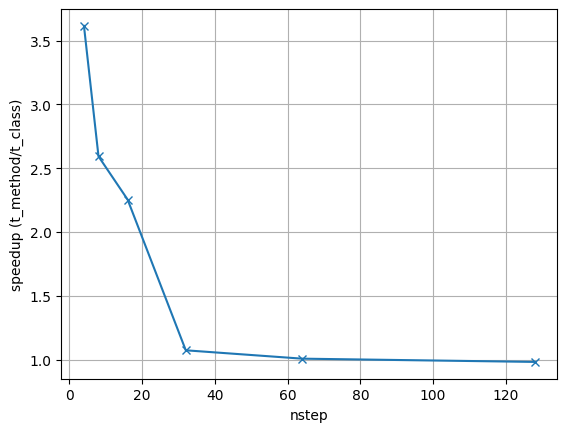

In [26]:
plt.plot(nsteps, t_method / t_class, marker='x', label='method')
plt.xlabel('nstep')
plt.ylabel('speedup (t_method/t_class)')
plt.grid()

So, for low nstep, (about 4 to 32 steps) we can get a 2x to 1.2x speedup by reusing the threadpool.

See the "Advanced Usage" section for how to use persistent threadpools with the method `rollout.rollout`.